In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import display, clear_output
import functools
import glob
import os


In [20]:
title = ipw.HTML(value="<h1><b>LOGIN</b></h1>")
txt_userName = ipw.Text(value='user name',placeholder='enter user name',
        description='User Name:', disabled=False)
txt_pass = ipw.Password(value='password',placeholder='enter password',
        description='Password:',disabled=False)
btn_login = ipw.Button(description='Login', disabled=False,  
            button_style='success', tooltip='Login', icon='check')
login_valid = ipw.Valid(value=False)
login_valid.layout.vissible = "hidden"
login_row = ipw.HBox([btn_login,login_valid])
login3=ipw.VBox([title,txt_userName,txt_pass,login_row],
                layout=ipw.Layout(
                display='flex',
                flex_flow='column',
                border='solid 2px',
                align_items='stretch',
                width='30%'
            ))



In [21]:
def graficar_discount():

    # Lista de las rutas de las carpetas que contienen los archivos CSV
    carpetas = [
        '../../scrappers/acuenta/results',
        '../../scrappers/eltit/results',
        '../../scrappers/eltrebol/results',
        '../../scrappers/jumbo/results',
        '../../scrappers/santaisabel/results',
        '../../scrappers/unimarc/results'
    ]
    
    # Inicializar listas para almacenar los resultados
    cantidad = []
    promedio = []
    nombres_archivos = []
    nombres_carpetas = []
    
    # Iterar sobre las carpetas
    for carpeta in carpetas:
        # Extraer el nombre de la carpeta (ej. "acuenta", "eltit")
        nombre_carpeta = os.path.basename(os.path.dirname(carpeta))
        nombres_carpetas.append(nombre_carpeta)
        
        # Buscar todos los archivos .csv en la carpeta actual
        csv_files = glob.glob(os.path.join(carpeta, '*.csv'))
        cantidad_temporal = []
        promedio_temporal = []
        
        # Lista para almacenar los nombres de los archivos de la carpeta
        archivos_nombre_temporal = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]
        
        # Procesar cada archivo CSV en la carpeta
        for archivo in csv_files:
            df = pd.read_csv(archivo)
            df['price'] = pd.to_numeric(df['price'], errors='coerce')
            df['pre_discount'] = pd.to_numeric(df['pre_discount'], errors='coerce')
            
            # Verificar si hay valores nulos y eliminarlos si es necesario
            df = df.dropna(subset=['price', 'pre_discount'])
            df['descuento'] = df['price'] - df['pre_discount']
             
            if nombre_carpeta == "acuenta":
                # Solo para la carpeta "acuenta", se considera bodegazo
                bodegazo1000 = (df['price'] == 1000).sum()
                bodegazo2000 = (df['price'] == 2000).sum()
                bodegazo3000 = (df['price'] == 3000).sum()
                bodegazo = bodegazo1000 + bodegazo2000 + bodegazo3000
                descuentos = len(df[df['descuento'] < 0])
                total = -df['descuento'].sum()
                cantidad_temporal.append(int(descuentos + bodegazo)) 
                promedio_temporal.append(int(total / descuentos))
            else:
                descuentos = len(df[df['descuento'] < 0])
                cantidad_temporal.append(int(descuentos))
                total = -df['descuento'].sum()
                promedio_temporal.append(int(total / descuentos))
        
        cantidad.append(cantidad_temporal)
        promedio.append(promedio_temporal)
        nombres_archivos.append(archivos_nombre_temporal)
    
    # Graficar la cantidad de descuentos (gráfico 1)
    plt.figure(figsize=(10, 6))
    for i, cantidad_data in enumerate(cantidad):
        plt.plot(cantidad_data, label=f'{nombres_carpetas[i]}', marker='o')
    
    plt.title('Cantidad de Descuentos')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de Descuentos')
    
    # Establecer los ticks para todos los archivos CSV en todas las carpetas
    # Asegúrate de que el número de etiquetas coincida con el número de archivos de la primera carpeta
    plt.xticks(range(len(nombres_archivos[0])), nombres_archivos[0], rotation=45)
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("cantidad_descuentos.png", format='png')
    plt.show()  # Mostrar gráfico de cantidad de descuentos
    
    # Graficar el valor promedio de descuentos (gráfico 2)
    plt.figure(figsize=(10, 6))
    for i, promedio_data in enumerate(promedio):
        plt.plot(promedio_data, label=f'{nombres_carpetas[i]}', marker='s')
    
    plt.title('Valor Promedio de Descuentos')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Promedio')
    
    # Establecer los ticks para todos los archivos CSV en todas las carpetas
    plt.xticks(range(len(nombres_archivos[0])), nombres_archivos[0], rotation=45)
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig("valor_promedio_descuentos.png", format='png')
    plt.show()  # Mostrar gráfico de valor promedio de descuentos


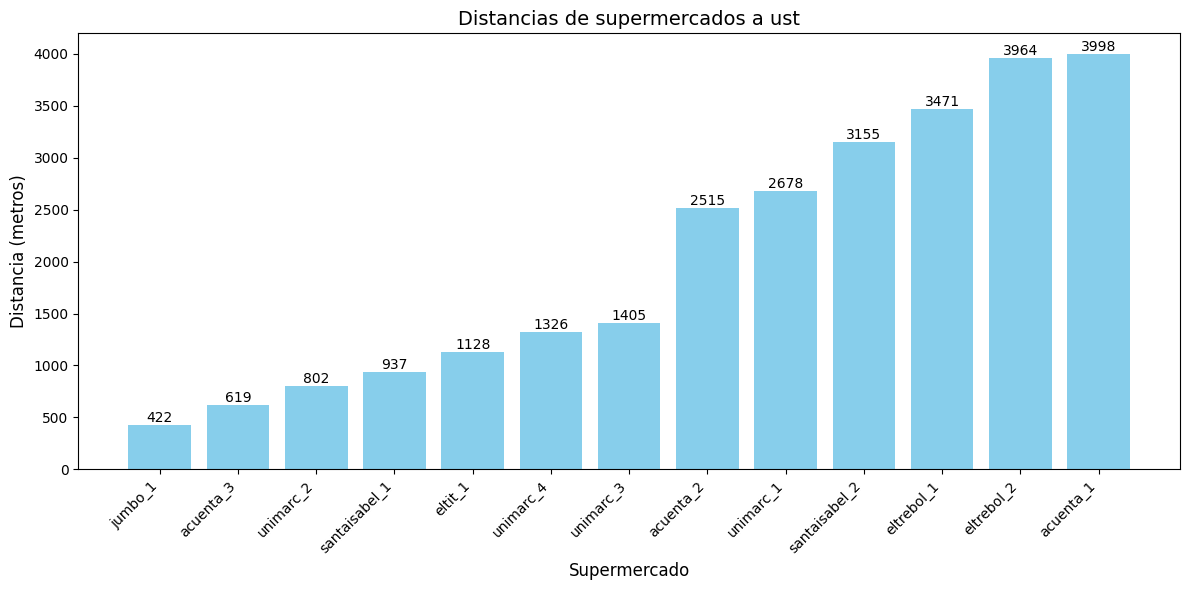

In [22]:
def plot_supermarket_distances(university, supermarkets=None):
    df = pd.read_csv('../utils/distance-to-nearest-supermarket/distances.csv')    
    uni_data = df[df['university'] == university]
    
    if uni_data.empty:
        print(f"No se encontraron datos para la universidad: {university}")
        return

    if supermarkets is not None:
        # Crear patrón de regex para buscar cualquier supermercado que comience con los nombres dados
        pattern = '|'.join([f'^{s}' for s in supermarkets])
        uni_data = uni_data[uni_data['supermarket'].str.contains(pattern)]
        
        if uni_data.empty:
            print(f"No se encontraron supermercados que coincidan con: {supermarkets}")
            return
    
    uni_data = uni_data.sort_values('distance')
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(uni_data['supermarket'], uni_data['distance'], color='skyblue')
    
    plt.title(f'Distancias de supermercados a {university}', fontsize=14)
    plt.xlabel('Supermercado', fontsize=12)
    plt.ylabel('Distancia (metros)', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    
    plt.show()

plot_supermarket_distances('ust')

In [23]:
# --- Función de graficado ---
def graficar_prom(n_archivos, **supermercados_checkbox):
    supermercados_seleccionados = [
        nombre for nombre, checked in supermercados_checkbox.items() if checked
    ]

    if not supermercados_seleccionados:
        print("⚠️ Selecciona al menos un supermercado.")
        return

    fechas_usar = fechas_disponibles[-n_archivos:]
    df_total = pd.DataFrame()

    for nombre in supermercados_seleccionados:
        ruta = Path(carpetas[nombre])
        archivos = sorted(ruta.glob('*.csv'), key=lambda x: datetime.strptime(x.stem, '%d-%m-%Y'))
        archivos_usar = archivos[-n_archivos:]

        fechas = []
        promedios = []

        for archivo in archivos_usar:
            try:
                fecha = datetime.strptime(archivo.stem, '%d-%m-%Y').date()
                df = pd.read_csv(archivo)
                df['price'] = pd.to_numeric(df['price'], errors='coerce')
                df = df.dropna(subset=['price'])
                fechas.append(fecha)
                promedios.append(df['price'].mean())
            except Exception as e:
                print(f"Error en {archivo.name}: {e}")
                continue

        if fechas:
            df_super = pd.DataFrame({
                'fecha': fechas,
                'promedio': promedios,
                'supermercado': nombre.capitalize()
            })
            df_total = pd.concat([df_total, df_super])

    if df_total.empty:
        print("⚠️ No hay datos disponibles para esta selección.")
        return
        

    df_total = df_total.sort_values('fecha')

    # --- Gráfico ---
    for supermercado, grupo in df_total.groupby('supermercado'):
        plt.plot(grupo['fecha'], grupo['promedio'], marker='o', label=supermercado)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.xticks(rotation=45)
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio ($)')
    plt.title(f'Precio promedio por supermercado (últimos {n_archivos} archivos)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [24]:
from pathlib import Path
from datetime import datetime
import pandas as pd

def graficar_prom2(n_archivos, **supermercados_checkbox):
    supermercados_seleccionados = [
        nombre for nombre, checked in supermercados_checkbox.items() if checked
    ]

    if not supermercados_seleccionados:
        print("⚠️ Selecciona al menos un supermercado.")
        return

    # Obtener archivos ordenados por fecha real
    route = Path('../utils/common-products-filter/results/')
    files_with_dates = []
    for f in route.iterdir():
        if f.is_file() and f.suffix == '.csv':
            try:
                fecha = datetime.strptime(f.stem, '%d-%m-%Y')
                files_with_dates.append((f, fecha))
            except ValueError:
                print(f"⚠️ Archivo ignorado por nombre inválido: {f.name}")

    # Ordenar por fecha real
    files_with_dates.sort(key=lambda x: x[1])

    # Extraer solo los archivos en orden
    files = [f for f, _ in files_with_dates]

    if n_archivos > len(files):
        print(f"⚠️ Solo hay {len(files)} archivos disponibles.")
        return

    # Tomar los archivos más recientes realmente por fecha
    files = files[-n_archivos:]

    # Obtener productos en común
    products_by_date = []
    for file in files:
        df = pd.read_csv(file)
        products = set(df['search'].dropna().unique())
        products_by_date.append(products)

    products_in_common = set.intersection(*products_by_date)
    supermercados = {
        "acuenta": ([], [], "aCuenta"), 
        "eltit": ([], [], "Eltit"), 
        "eltrebol": ([], [], "El Trébol"), 
        "jumbo": ([], [], "Jumbo"), 
        "santaisabel": ([], [], "Santa Isabel"), 
        "unimarc": ([], [], "Unimarc")
    }

    averages_records = []
    individual_records = []

    for file in files:
        df = pd.read_csv(file)
        date = datetime.strptime(file.name.replace(".csv", ""), "%d-%m-%Y").date()
        df = df[df['search'].isin(products_in_common)]

        for name in supermercados_seleccionados:
            prices = pd.to_numeric(df[f"price_{name}"], errors='coerce').dropna()
            
            if not prices.empty:
                supermercados[name][0].append(prices.mean())
                supermercados[name][1].append(date)

                for price in prices:
                    individual_records.append({
                        "date": date,
                        "price": price,
                        "supermarket": supermercados[name][2]
                    })

    if not any(len(data[0]) > 0 for data in supermercados.values()):
        print("⚠️ No hay datos disponibles para esta selección.")
        return

    df_averages = pd.DataFrame({
        "date": sum([supermercados[name][1] for name in supermercados_seleccionados], []),
        "average": sum([supermercados[name][0] for name in supermercados_seleccionados], []),
        "supermarket": sum([[supermercados[name][2]] * len(supermercados[name][0]) for name in supermercados_seleccionados], [])
    })

    df_individual = pd.DataFrame(individual_records)

    df_averages.sort_values(by="date", inplace=True)
    df_individual.sort_values(by="date", inplace=True)

    plt.figure(figsize=(12, 6))

    for supermarket, df_group in df_averages.groupby("supermarket"):
        plt.plot(df_group["date"], df_group["average"], marker='o', label=f"{supermarket} (promedio)", linewidth=2)

    for supermarket, df_group in df_individual.groupby("supermarket"):
        plt.scatter(df_group["date"], df_group["price"], alpha=0.4, label=f"{supermarket} (producto)", s=25)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xlabel('Fecha')
    plt.ylabel('Promedio de Precios')
    plt.title(f'Precio promedio según fecha (últimos {n_archivos} archivos)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()



In [25]:
from pathlib import Path
from datetime import datetime
import matplotlib.dates as mdates
# --- Configuración de rutas ---
carpetas = {
    'acuenta': '../scrappers/acuenta/results',
    'eltit': '../scrappers/eltit/results',
    'eltrebol': '../scrappers/eltrebol/results',
    'jumbo': '../scrappers/jumbo/results',
    'santaisabel': '../scrappers/santaisabel/results',
    'unimarc': '../scrappers/unimarc/results'
}

carpeta_base = Path('../utils/common-products-filter/results/')
archivos_base = []
for archivo in carpeta_base.glob('*.csv'):
    try:
        fecha = datetime.strptime(archivo.stem, '%d-%m-%Y')
        archivos_base.append((archivo, fecha))
    except ValueError:
        print(f"⚠️ Archivo ignorado por nombre inválido: {archivo.name}")

# Ordenar por la fecha datetime, no por nombre
archivos_base.sort(key=lambda x: x[1])

# Lista de fechas y archivos ordenados
fechas_disponibles = [fecha.date() for _, fecha in archivos_base]
archivos_ordenados = [archivo for archivo, _ in archivos_base]

total_archivos = len(fechas_disponibles)
print(total_archivos)
# --- Widgets de control ---

n_archivos_slider = ipw.IntSlider(
    value=8,
    min=1,
    max=total_archivos,
    step=1,
    description='Últimos archivos:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

checkbox_widgets = {
    name: ipw.Checkbox(value=(name in ['acuenta', 'jumbo']), description=name.capitalize())
    for name in carpetas.keys()
}

checkbox_box = ipw.VBox(list(checkbox_widgets.values()))

# --- Conectar widgets a la función ---
widget_args = {key: cb for key, cb in checkbox_widgets.items()}
widget_args['n_archivos'] = n_archivos_slider

# --- Mostrar UI ---
ui = ipw.VBox([
    n_archivos_slider,
    ipw.Label("Selecciona supermercados:"),
    checkbox_box
])


51


In [26]:
fluctuacion_discount= ipw.interactive(graficar_discount)

In [27]:
fluctuacion_periodo = ipw.interactive(
    graficar_prom, 
    n_archivos=n_archivos_slider,
    **checkbox_widgets
)


In [28]:
fluctuacion_periodo2 = ipw.interactive(
    graficar_prom2, 
    n_archivos=n_archivos_slider,
    **checkbox_widgets
)


In [29]:

tab = ipw.Tab()
tab.children = [login3, fluctuacion_periodo,fluctuacion_discount]
tab.titles = ["Login","Fluctuacion por periodo", "beneficios"]
tab

In [ ]:

tab = ipw.Tab()
tab.children = [login3, fluctuacion_periodo, sucursales, tipo_producto, beneficios]
tab